In [1]:
import numpy as np
import sympy as sp
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math
def eq_disp(varstring, expr):
    display(Latex(f"${varstring}={sp.latex(expr)}$"))

def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

s = sp.symbols('s')
t, zeta, omega = sp.symbols('t, zeta, omega', positive=True, real=True)

# E5.19

From the Transfer function we extract $\omega_n$ and $\zeta$

In [2]:
omega = sp.sqrt(7)
zeta = sp.Rational(3175, 1000)/2/omega
R = 1/s
T = omega**2/(s**2 + 2*zeta*omega*s + omega**2)
Y = R*T
eq_disp('Y(s)', Y)

<IPython.core.display.Latex object>

The formula for percent overshoot is:
$$\sigma_p \%=\frac{y\left(T_p\right)-y(\infty)}{y(\infty)} \times 100 \%$$
where 
$$\left.\frac{d y(t)}{d t}\right|_{t=T_p}=\left.0\right|_{(\text {first })}$$
First we must find $y(t)$

Transform to the time domain

In [3]:
y = sp.inverse_laplace_transform(Y.apart(), s, t)
eq_disp('y', y)

<IPython.core.display.Latex object>

The derivative in the laplace domain is obtained simply by multiplying by s (in case initial conditions are zero)

In [4]:
dy = sp.inverse_laplace_transform((s*Y).apart(), s, t)
eq_disp('\\frac{dy}{dt}', sp.N(dy,3))

<IPython.core.display.Latex object>

Peak time is then calculated

In [5]:
sol = sp.solve(dy.evalf(5), t)
Tp = min([x for x in sol if x != 0])
eq_disp('T_p', sp.N(Tp,3))

<IPython.core.display.Latex object>

Now the steady state value is calculated by 
$$\lim_{t\rightarrow\infty}y(t)$$

In [6]:
y_ss = sp.limit(y, t, sp.oo)
eq_disp('y(\infty)', y_ss)

<IPython.core.display.Latex object>

Finally %overshoot can be calculated

In [7]:
sigma_p = ((y.subs(t, Tp) - y_ss)/y_ss*100).evalf()
eq_disp('\\sigma_p\%', sp.N(sigma_p,3))


<IPython.core.display.Latex object>

The setling time at 2% threshold is calculated by:
$$
T_s=4 \tau=\frac{4}{\xi \omega_n}
$$

In [8]:
Ts = 4/(zeta*omega)
eq_disp('T_s', sp.N(Ts,3))

<IPython.core.display.Latex object>

## b)

To verify our results we plot $y(t)$ and anotate the plot with the peak time $T_p$ and the settling time $T_s$ 

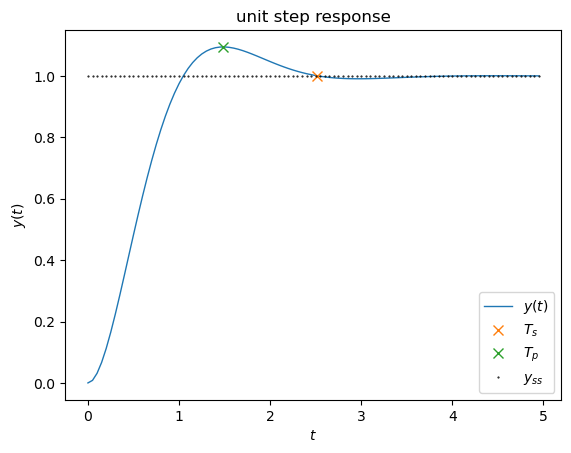

In [9]:
y_f = sp.lambdify(t, y)
tspan = np.r_[0:5:0.05]
plt.plot(tspan, y_f(tspan), linewidth=1)
plt.plot(float(Ts), y_f(float(Ts)),linestyle='None', markersize=7, marker='x')
plt.plot(float(Tp), y_f(float(Tp)),linestyle='None', markersize=7, marker='x')
plt.plot(tspan, float(y_ss)*np.ones(len(tspan)), 'k.', markersize=1)
plt.legend(['$y(t)$', '$T_s$', '$T_p$', '$y_{ss}$'])
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('unit step response')
plt.show()

In [10]:
import numpy as np
import sympy as sp
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math, Image
def eq_disp(varstring, expr):
    display(Latex(f"${varstring}={sp.latex(expr)}$"))

# Function for displaying expressions
def eq_disp_unit(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))
    
def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

# P5.7

In [11]:
# Moment of inertia of the equipment and man [kg*m^2]
I = 25

s, t, K_1, K_2, K_3sym = sp.symbols('s, t, K_1, K_2, K_3')

## a)

Input
$$ R(t) = t \Leftrightarrow R(s) = \frac{1}{s^2}$$

The transfer function is found

In [12]:
G1 = (K_1*K_2/(I*s))/(1 + K_1*K_2*K_3sym/(I*s))

G2 = 1/s

T = sp.simplify(G1*G2/(1 + G1*G2))
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

The tracking error
$$E(s) = R(s) - Y(s) = R(s) - T(s)R(s) = R(s)(1-T(s))$$

So we get
$$E(s) = \frac{1}{s^2}(1-T(s))$$

In [13]:
# Input
R = 1/(s**2)

E = sp.simplify(1/s**2*(1-T))

eq_disp('E(s)', E)

<IPython.core.display.Latex object>

The steady state error $e_{ss}$ is found by
$$ e_{ss} = \lim_{t \to \infty} e(t) = \lim_{s \to 0} s E(s)$$

In [14]:
e_ss = sp.limit(s*E, s, 0)
eq_disp('e_{ss}', e_ss)

<IPython.core.display.Latex object>

The maximum steady state error is
$$e_{ss,max} = 0.01 m$$

In [15]:
e_ss_max = 0.01
K_3 = sp.solve(e_ss - e_ss_max, K_3sym)[0]
eq_disp_unit('K_3', K_3, 'm')

<IPython.core.display.Latex object>

## b)

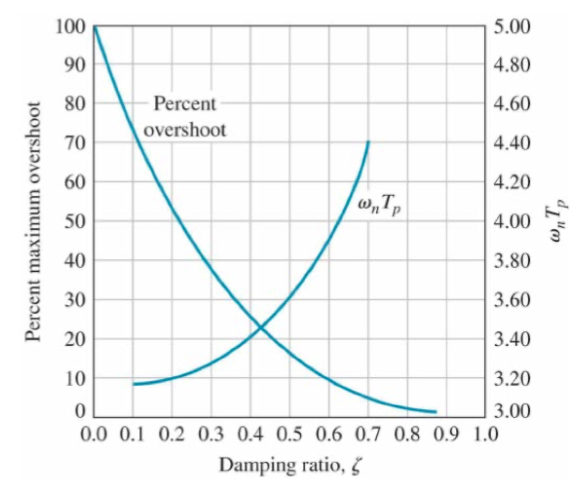

In [17]:
Image('P.O..png')

From the diagram it is seen that for a percent overshoot (P.O.) of 10% the corresponding damping ratio is $\zeta=0.6$

In [18]:
zeta = 0.6
T_a = T.subs(K_3sym, K_3)
eq_disp('T',T_a)

<IPython.core.display.Latex object>

Solve for the n poles

In [19]:
p, q = (T).as_numer_denom()
poles = sp.solve(q,s)
        
for i, pole in enumerate(poles):
    eq_disp(f'-s_{i}', pole)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The poles 1 and 2 are given by
$$s_{1,2} = -\zeta \omega_n \mp j\omega_n \sqrt{1-\zeta^2}$$

This means that
\begin{equation}
\zeta \omega_n = \frac{K_1 K_2 0.01}{50}
\label{eq:pole}
\end{equation}

The response of a second order system is given by
$$T(s) = \frac{\omega_n^2}{s^2+2\zeta \omega_n s + \omega_n^2}$$

$$Y(s) = \frac{\omega_n^2}{s^2+2\zeta \omega_n s + \omega_n^2}R(s)$$

In this case:

In [20]:
eq_disp('T', sp.expand(T_a))

<IPython.core.display.Latex object>

Meaning that
\begin{equation}
\omega_n^2 = \frac{K_1 K_2}{25}
\label{eq:T}
\end{equation}

Using equations \ref{eq:pole} and \ref{eq:T} the constant $K_1K_2$ is found

In [21]:
K1K2sym,omegasym = sp.symbols('K1K2,omega_n')
eq1 = sp.Eq(zeta*omegasym,K1K2sym*K_3/50)
eq2 = sp.Eq(omegasym**2,K1K2sym/25)
K_1K_2_b,omega_n_b = sp.solve([eq1,eq2],(K1K2sym,omegasym))[1]

eq_disp('\\omega_n',omega_n_b)
eq_disp('K_1K_2',K_1K_2_b)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## c)

In [22]:
# Input
R = 1/s

Y = sp.expand(T*R)

eq_disp('Y(s)', Y)

<IPython.core.display.Latex object>

Where the $Y(s)$ can be written on the form

\begin{align*}
Y(s) &= \frac{\omega_n^2}{s^2+2\zeta \omega_n s + \omega_n^2}R(s) \\
&= \frac{\omega_n^2}{s(s^2+2\zeta \omega_n s + \omega_n^2)}
\end{align*}

So
$$\omega_n^2 = \frac{K_1 K_2}{25}$$

and
$$2 \zeta \omega_n = \frac{K_1 K_2 K_3}{25}$$

This gives the $y(t)$ in the time domain as
$$y(t) = 1 - \frac{1}{\beta}e^{-\zeta \omega_n t}sin(\omega_n \beta t +\theta)$$

Where
$$\beta = \sqrt{1-\zeta^2}$$
$$\theta = cos^{-1}\zeta$$

In [23]:
beta, zeta, omega_n, theta = sp.symbols('beta,zeta,omega_n,theta')
y = sp.simplify(1 - 1/beta*sp.exp(-zeta*omega_n*t)*sp.sin(omega_n*beta*t+theta))
eq_disp('y(t)',y)

<IPython.core.display.Latex object>

Integrating this w.r.t to time from 0 to $\infty$

Squaring $y(t)$ and integrating the result gives the ISE (see example 5.7 in the book)

$$ISE = \int_0^\infty \left(1 - \frac{1}{\beta}e^{-\zeta \omega_n t}sin(\omega_n \beta t +\theta)\right)^2 dt$$


In [24]:
from sympy import *
ISE = sp.integrate(y**2, (t, 0, oo))
eq_disp('ISE',ISE)

<IPython.core.display.Latex object>

In [25]:
omega_n = sp.sqrt(K1K2sym/25)
eq_disp('\\omega_n',omega_n)

zeta = K1K2sym*K_3sym/(2*25*omega_n)
eq_disp('\\zeta',zeta)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
beta = sp.sqrt(1-zeta**2)
eq_disp('\\beta',beta)

theta = sp.acos(zeta)
eq_disp('\\theta',theta)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [27]:
y = sp.simplify(1 - 1/beta*sp.exp(-zeta*omega_n*t)*sp.sin(omega_n*beta*t+theta))
eq_disp('y(t)',y)

<IPython.core.display.Latex object>

Squaring $y(t)$ and integrating the result gives the ISE as in example 5.7 in the book (We consulted xuping about this last part of the problem and was told it was okay to skip since we have not yet learned the theory)  
The following approach doesnt work

In [ ]:
ISE = sp.integrate(y**2, (t, 0, oo))
eq_disp('ISE',ISE)

Differentiating the ISE w.r.t. $K_1 K_2$

In [ ]:
ISE_diff = sp.diff(ISE,K1K2sym)
ISE_diff

Setting the differentiated ISE equal to 0 to find the minimum

In [ ]:
K1K2 = sp.solve(ISE_diff,K1K2sym)
eq_disp('K_1K_2', K1K2)